In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.interpolate as si
import scipy.optimize as so

%matplotlib inline

### Power analysis

In [2]:
pow_l = pd.read_csv("/cd4_output/power_results.cd4.txt", index_col=0, sep='\t')
pow_f = pd.read_csv("/monocyte_output/power_results.mono.txt", index_col=0, sep='\t')
pow_l['variable'] = np.where(pow_l['var_code']==0, 'x_count', 'y_count')
pow_f['variable'] = np.where(pow_f['var_code']==0, 'x_count', 'y_count')
pow_l.head()

,var_code,k,beta,n_genes,n_true_X,n_true_Y,n_other_X,n_other_Y,TPR,variable
xcount_0.05_1,0,1,0.05,100,0,0,2,3,0.0,x_count
xcount_0.05_2,0,2,0.05,100,0,0,3,4,0.0,x_count
xcount_0.05_3,0,3,0.05,100,0,0,4,6,0.0,x_count
xcount_0.05_4,0,4,0.05,100,0,0,0,3,0.0,x_count
xcount_0.05_5,0,5,0.05,100,0,0,0,0,0.0,x_count


In [3]:
pow_f.head()

,var_code,k,beta,n_genes,n_true_X,n_true_Y,n_other_X,n_other_Y,TPR,variable
xcount_0.05_1,0,1,0.05,100,0,0,4,12,0.00,x_count
xcount_0.05_2,0,2,0.05,100,0,0,12,13,0.00,x_count
xcount_0.05_3,0,3,0.05,100,0,0,3,5,0.00,x_count
xcount_0.05_4,0,4,0.05,100,1,0,9,9,0.01,x_count
xcount_0.05_5,0,5,0.05,100,0,0,4,9,0.00,x_count


Save summary of results (median TPR by variable and tissue)

In [4]:
summ = {}
med_ = pow_l.groupby(['variable', 'beta']).median()['TPR'].reset_index()
med_ = pd.pivot(med_, index='beta', columns='variable', values='TPR')
med_.columns.name=''
med_.columns = ['x_count_power', 'y_count_power']
print(med_)
summ['CD4s'] = med_

med_ = pow_f.groupby(['variable', 'beta']).median()['TPR'].reset_index()
med_ = pd.pivot(med_, index='beta', columns='variable', values='TPR')
med_.columns.name=''
med_.columns = ['x_count_power', 'y_count_power']
print(med_)
summ['Monocytes'] = med_

summ = pd.concat(summ, axis=1)
summ

      x_count_power  y_count_power
beta                              
0.05          0.000          0.000
0.10          0.000          0.000
0.20          0.105          0.130
0.40          0.740          0.765
0.60          0.930          0.940
0.80          0.980          0.980
1.00          0.985          0.990
      x_count_power  y_count_power
beta                              
0.05          0.000          0.000
0.10          0.000          0.000
0.20          0.040          0.085
0.40          0.630          0.690
0.60          0.895          0.910
0.80          0.960          0.980
1.00          0.990          0.990


CD4s                   Monocytes              
     x_count_power y_count_power x_count_power y_count_power
beta                                                        
0.05         0.000         0.000         0.000         0.000
0.10         0.000         0.000         0.000         0.000
0.20         0.105         0.130         0.040         0.085
0.40         0.740         0.765         0.630         0.690
0.60         0.930         0.940         0.895         0.910
0.80         0.980         0.980         0.960         0.980
1.00         0.985         0.990         0.990         0.990

In [5]:
summ.to_csv("median_estimated_power.compiled.txt", sep='\t')

In [6]:
pd.read_csv("median_estimated_power.compiled.txt", sep='\t', index_col=0, header=[0, 1])

CD4s                   Monocytes              
     x_count_power y_count_power x_count_power y_count_power
beta                                                        
0.05         0.000         0.000         0.000         0.000
0.10         0.000         0.000         0.000         0.000
0.20         0.105         0.130         0.040         0.085
0.40         0.740         0.765         0.630         0.690
0.60         0.930         0.940         0.895         0.910
0.80         0.980         0.980         0.960         0.980
1.00         0.985         0.990         0.990         0.990

Exclude beta=0.05 from here (power is close to zero/not well estimated)

In [7]:
pow_l = pow_l.loc[pow_l['beta'] > 0.05]
pow_f = pow_f.loc[pow_f['beta'] > 0.05]

#### CD4s vs. Monocytes

In [8]:
def plot_power(ax, v, df, color='k', jitter=True, label=None):
    df = df.loc[df.index.str.startswith(v)].copy()
    jitter_width=0.005
    
    # medians
    meds = df.groupby('beta').median().sort_values('beta')
    ax.plot(meds.index, meds['TPR'], color=color, lw=1, alpha=0.6)

    # points
    xs = df['beta']
    ys = df['TPR']
    if jitter:
        xs += np.random.random(len(xs))*jitter_width-(jitter_width/2)
    ax.scatter(xs, ys, edgecolor='none', facecolor=color, alpha=0.45, s=10, 
               label=label)

    ax.set_xticks(meds.index)
    ax.set_ylabel("Power", size=7)
    ax.set_xlabel("Simulated effect size", size=7)
    return ax

In [9]:
def plot_power_annot2(ax, v, df, color='k', lcolor='k', jitter=True, label=None,
                      acolor='0.6', alw=1, curve_f=None):
    """
    set y-ticks using estimated power values for each beta
    """
    df = df.loc[df.index.str.startswith(v)].copy()
    jitter_width=0.005
    
    # medians
    meds = df.groupby('beta').median().sort_values('beta')
    if curve_f is None:
        ax.plot(meds.index, meds['TPR'], color=lcolor, lw=1, zorder=2)
    else:
        popt, pcov = so.curve_fit(f, df['beta'], df['TPR'])
        xs = np.linspace(0.1, 1, 40)
        ys = np.array(list(map(lambda x: f(x, popt[0], popt[1]), xs)))
        ax.plot(xs, ys, color=lcolor, lw=1, zorder=2, label="1-a*e^(bx)\na={0:.1f},b={1:.1f}".format(popt[0], popt[1]))
        ax.legend(loc='lower right', fontsize=7)

    # points
    xs = df['beta']
    ys = df['TPR']
    if jitter:
        xs += np.random.random(len(xs))*jitter_width-(jitter_width/2)
    ax.scatter(xs, ys, edgecolor='none', facecolor=color, alpha=0.3, s=8, 
               label=label, zorder=3)
    
    xlim = (0.05, 1.05)
    ylim = (-0.05, 1.05)
    ax.set_xlim(xlim)
    ax.set_ylim(ylim)
    
    yticks = [1.0]
    for b in [0.1, 0.2, 0.4, 0.6]:
        yb = meds.at[b, 'TPR']
        ax.plot([xlim[0], b], [yb, yb], ls=':', color=acolor, lw=1, zorder=1)
        ax.plot([b, b], [ylim[0], yb], ls=':', color=acolor, lw=1, zorder=1)
        yticks.append(yb)
    ax.plot(xlim, [1, 1], ls=':', color=acolor, lw=1, zorder=1)

    ax.set_xticks(meds.index)
    yticks = sorted(list(set(yticks)))
    ax.set_yticks(yticks)
    ax.set_yticklabels(list(map(lambda s: "{:.2f}".format(s), yticks)))
    
    ax.set_ylabel("Power", size=7)
    ax.set_xlabel("Simulated effect size", size=7)
    return ax

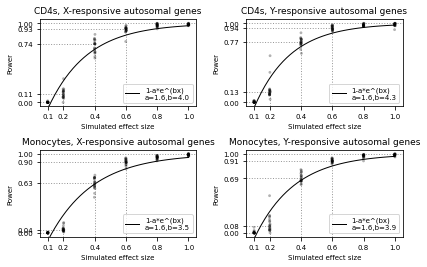

In [10]:
def f(x, a, b):
    return 1-a*np.exp(-b*x)

fig, axes = plt.subplots(2, 2, figsize=(6.5, 4))
fig.subplots_adjust(hspace=0.5, wspace=0.32)

for (i, cell, df) in zip((0, 1), ('CD4s', 'Monocytes'), (pow_l, pow_f)):
    for (c, ax) in zip(('x', 'y'), (axes[i])):
        clab = '{}count'.format(c)
        ax = plot_power_annot2(ax, clab, df, curve_f=f)
        
        ax.set_title('{0}, {1}-responsive autosomal genes'.format(cell, c.upper()),
                     size=9)
        
        for lab in ax.get_xticklabels():
            lab.set_size(7)
        for lab in ax.get_yticklabels():
            lab.set_size(7)

fig.savefig("power_comparison.allfour_annotated.pdf")

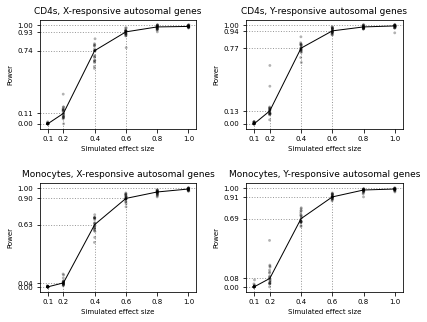

In [15]:
# no curve fit
fig, axes = plt.subplots(2, 2, figsize=(6.5, 5))
fig.subplots_adjust(hspace=0.5, wspace=0.32)

for (i, cell, df) in zip((0, 1), ('CD4s', 'Monocytes'), (pow_l, pow_f)):
    for (c, ax) in zip(('x', 'y'), (axes[i])):
        clab = '{}count'.format(c)
        ax = plot_power_annot2(ax, clab, df)
        
        ax.set_title('{0}, {1}-responsive autosomal genes'.format(cell, c.upper()),
                     size=9)
        
        for lab in ax.get_xticklabels():
            lab.set_size(7)
        for lab in ax.get_yticklabels():
            lab.set_size(7)

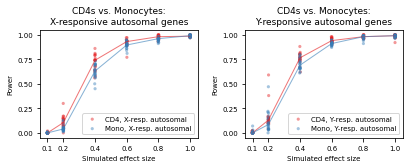

In [16]:
fig, axes = plt.subplots(1, 2, figsize=(6.5, 2.5))
fig.subplots_adjust(bottom=0.2, top=0.8, wspace=0.3)
for (ax, v) in zip(axes, ('xcount', 'ycount')):
    c = v[0].upper()
    ax = plot_power(ax, v, pow_l, color='#e41a1c', label='CD4, {}-resp. autosomal'.format(c))
    ax = plot_power(ax, v, pow_f, color='#377eb8', label='Mono, {}-resp. autosomal'.format(c))
    ax.legend(fontsize=7)
    
    for lab in ax.get_xticklabels():
        lab.set_size(7)
    for lab in ax.get_yticklabels():
        lab.set_size(7)
    ax.set_title("CD4s vs. Monocytes:\n{}-responsive autosomal genes".format(c), size=9)
fig.savefig("power_comparison.CD4_vs_monocytes.pdf")

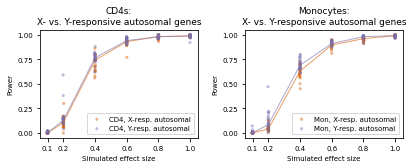

In [17]:
fig, axes = plt.subplots(1, 2, figsize=(6.5, 2.5))
fig.subplots_adjust(bottom=0.2, top=0.8, wspace=0.3)
for (ax, df, celltype) in zip(axes, (pow_l, pow_f), ('CD4s', 'Monocytes')):
    ax = plot_power(ax, 'xcount', df, color='#d95f02', label='{0}, X-resp. autosomal'.format(celltype[:3]))
    ax = plot_power(ax, 'ycount', df, color='#7570b3', label='{0}, Y-resp. autosomal'.format(celltype[:3]))
    ax.legend(fontsize=7)
    
    for lab in ax.get_xticklabels():
        lab.set_size(7)
    for lab in ax.get_yticklabels():
        lab.set_size(7)
    ax.set_title("{0}:\nX- vs. Y-responsive autosomal genes".format(celltype), size=9)
fig.savefig("power_comparison.Xresp_vs_Yresp.pdf")

### Estimated difference in number of discovered genes

In [18]:
summ

CD4s                   Monocytes              
     x_count_power y_count_power x_count_power y_count_power
beta                                                        
0.05         0.000         0.000         0.000         0.000
0.10         0.000         0.000         0.000         0.000
0.20         0.105         0.130         0.040         0.085
0.40         0.740         0.765         0.630         0.690
0.60         0.930         0.940         0.895         0.910
0.80         0.980         0.980         0.960         0.980
1.00         0.985         0.990         0.990         0.990

In [11]:
xres_l = pd.read_table("/sca-immune/Autosomal_linear_regressions/cd4/cd4_autosomal_Xresponse.txt", sep='\t', index_col=0)
yres_l = pd.read_table("/sca-immune/Autosomal_linear_regressions/cd4/cd4_autosomal_Yresponse.tx", sep='\t', index_col=0)
sig_effects_x = xres_l.loc[(xres_l['padj'] < 0.05) & (np.abs(xres_l['log2FoldChange']) > 0.1), 'log2FoldChange']
sig_effects_y = yres_l.loc[(yres_l['padj'] < 0.05) & (np.abs(yres_l['log2FoldChange']) > 0.1), 'log2FoldChange']

xres_l.head()

,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj,Gene,gene_id.84,gene_type.84,chr,start,stop,gene_name.107,gene_id.107,gene_type.107
A1BG,121.511644,0.335755,0.141389,2.374700,0.017563,0.312327,A1BG,ENSG00000121410,protein_coding,chr19,58345178,58353499,A1BG,ENSG00000121410,protein_coding
A1BG-AS1,184.361385,0.255913,0.110724,2.311261,0.020818,0.338270,A1BG-AS1,ENSG00000268895,antisense,chr19,58347751,58355183,A1BG-AS1,ENSG00000268895,lncRNA
A2M,1136.805668,0.120355,0.154994,0.776514,0.437446,0.901629,A2M,ENSG00000175899,protein_coding,chr12,9067664,9116229,A2M,ENSG00000175899,protein_coding
A2M-AS1,231.609586,-0.143663,0.154731,-0.928473,0.353162,0.869191,A2M-AS1,ENSG00000245105,antisense,chr12,9065177,9068060,A2M-AS1,ENSG00000245105,lncRNA
AAAS,1206.838612,-0.070724,0.094801,-0.746020,0.455655,0.907124,AAAS,ENSG00000094914,protein_coding,chr12,53307456,53324864,AAAS,ENSG00000094914,protein_coding


In [12]:
xres_f = pd.read_table("/sca-immune/Autosomal_linear_regressions/monocyte/monocyte_autosomal_Xresponse.txt", sep='\t', index_col=0)
yres_f = pd.read_table("/sca-immune/Autosomal_linear_regressions/monocyte/monocyte_autosomal_Yresponse.txt", sep='\t', index_col=0)

sig_effects_xf = xres_f.loc[(xres_l['padj'] < 0.05) & (np.abs(xres_f['log2FoldChange']) > 0.1), 'log2FoldChange']
sig_effects_yf = yres_f.loc[(yres_l['padj'] < 0.05) & (np.abs(yres_f['log2FoldChange']) > 0.1), 'log2FoldChange']

xres_f.head()

,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj,Gene,gene_id.84,gene_type.84,chr,start,stop,gene_name.107,gene_id.107,gene_type.107
A1BG,181.300241,0.465601,0.115491,4.031491,0.000055,0.023448,A1BG,ENSG00000121410,protein_coding,chr19,58345178,58353499,A1BG,ENSG00000121410,protein_coding
A1BG-AS1,181.004084,0.026488,0.124221,0.213236,0.831143,0.999998,A1BG-AS1,ENSG00000268895,antisense,chr19,58347751,58355183,A1BG-AS1,ENSG00000268895,lncRNA
AAAS,864.098913,-0.150988,0.092459,-1.633026,0.102463,0.999998,AAAS,ENSG00000094914,protein_coding,chr12,53307456,53324864,AAAS,ENSG00000094914,protein_coding
AACS,291.065996,-0.086852,0.088731,-0.978828,0.327665,0.999998,AACS,ENSG00000081760,protein_coding,chr12,125065379,125143333,AACS,ENSG00000081760,protein_coding
AAED1,913.900169,0.095033,0.058436,1.626267,0.103893,0.999998,AAED1,ENSG00000158122,protein_coding,chr9,96639577,96655303,PRXL2C,ENSG00000158122,protein_coding


Get observed effect-size distribution for expressed, protein-coding autosomal genes

In [13]:
def plot_hist_unobserved_effects(ax, f, pow_df, deres, v, bin_width=0.05, b_range=[0.1, 3.56]):
    df = pow_df.loc[pow_df['variable']==v].copy()
    b0, b1 = b_range
    
    # extract observed effects for protein-coding autosomal genes
    eff_obs = deres.loc[deres['padj'] < 0.05, 'log2FoldChange']
    
    # consider only effects with magnitdue > 0.1
    eff_obs = np.abs(eff_obs)
    eff_obs = eff_obs[(eff_obs >= b0) & (eff_obs <= b1)]
    
    # fit exponential curve
    popt, pcov = so.curve_fit(f, df['beta'], df['TPR'])
    
    # estimate density for values of beta in range [0.1, 1.0] in bins of width <bin_width>
    
    # set up bins and plot observed-effects hist
    bwidth = bin_width
    bins = int((b1 - b0) / bwidth)
    cts, breaks, patches = ax.hist(eff_obs, range=(b0, b1), bins=bins,
                                   label="obs. genes, |log2fc| ≥ 0.1]\n(n={})".format(len(eff_obs)))
    
    # estimate power at bin center
    xs1 = np.arange(bins)*bwidth + b0+(0.5*bwidth)
    est_power = np.array(list(map(lambda x: f(x, popt[0], popt[1]), xs1)))
    
    # get estimated number of true effects
    cts_true_est = cts / est_power
    ax.bar(xs1, cts_true_est-cts, bwidth, bottom=cts, color='#a6cee3',
           label="unobs. genes, |log2fc| ≥ 0.1\n(n={})".format(int(np.sum(cts_true_est-cts))))
    
    ax.set_xticks([0.1, 0.2, 0.4, 0.6, 0.8, 1.0])
    ax.legend(loc='upper right', fontsize=7)
    ax.set_xlabel('|Effect size (log2 fold change)|', size=7)
    ax.set_ylabel('Number of genes', size=7)
    
    return ax, cts, cts_true_est

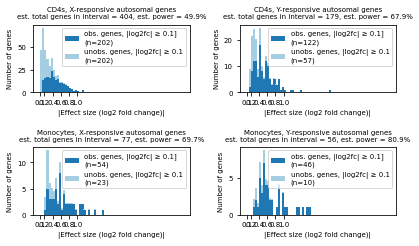

In [14]:
fig, axes = plt.subplots(2, 2, figsize=(6.5, 3.5))
fig.subplots_adjust(hspace=0.8, wspace=0.32)

v_list = ['x', 'y']
cell_list = ['CD4s', 'Monocytes']
pow_list = [pow_l, pow_f]
res_list = [[xres_l, yres_l], 
            [xres_f, yres_f]]
for i in (0, 1):      # cell type
    for j in (0, 1):  # x vs. y
        ax = axes[i, j]
        cell = cell_list[i]
        v = '{}_count'.format(v_list[j])
        
        ax, cts, cts_true_est = plot_hist_unobserved_effects(ax, f, pow_list[i], res_list[i][j], 
                                                             v)
        title = '{0}, {1}-responsive autosomal genes'.format(cell, v_list[j].upper())
        n_tot_est = int(np.sum(cts_true_est))
        est_power = np.sum(cts) / np.sum(cts_true_est)
        title += '\nest. total genes in interval = {0}, est. power = {1:.1%}'.format(n_tot_est, est_power)
        ax.set_title(title, size=7)
        
        for lab in ax.get_xticklabels():
            lab.set_size(7)
        for lab in ax.get_yticklabels():
            lab.set_size(7)

fig.savefig("estimated_unobserved_gene_histograms.pdf")

[ 1. 14. 16. 17. 16. 24. 17. 14. 15. 10. 10.  9.  8.  7.  5.  4.  2.  3.
  2.  1.  3.  1.  1.  0.  0.  0.  0.  1.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  1.]
[46.91446258 71.05212185 46.89188927 36.9970392  28.74885967 37.72597382
 24.23403077 18.54083852 18.77197323 11.97401508 11.56414155 10.12341927
  8.80133718  7.56511124  5.32644343  4.21178171  2.08606001  3.10509986
  2.05712676  1.02331525  3.05714773  1.01557567  1.01274342  0.
  0.          0.          0.          1.00469984  0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.     

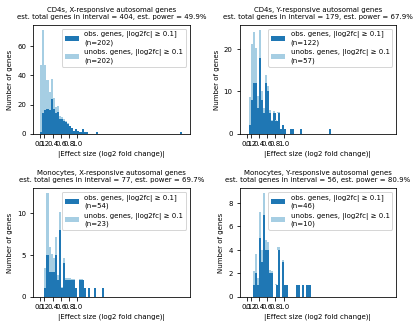

In [40]:
fig, axes = plt.subplots(2, 2, figsize=(6.5, 5))
fig.subplots_adjust(hspace=0.5, wspace=0.32)

v_list = ['x', 'y']
cell_list = ['CD4s', 'Monocytes']
pow_list = [pow_l, pow_f]
res_list = [[xres_l, yres_l], 
            [xres_f, yres_f]]
for i in (0, 1):      # cell type
    for j in (0, 1):  # x vs. y
        ax = axes[i, j]
        cell = cell_list[i]
        v = '{}_count'.format(v_list[j])
        
        ax, cts, cts_true_est = plot_hist_unobserved_effects(ax, f, pow_list[i], res_list[i][j], 
                                                             v)
        print(cts)
        print(cts_true_est)
        title = '{0}, {1}-responsive autosomal genes'.format(cell, v_list[j].upper())
        n_tot_est = int(np.sum(cts_true_est))
        est_power = np.sum(cts) / np.sum(cts_true_est)
        title += '\nest. total genes in interval = {0}, est. power = {1:.1%}'.format(n_tot_est, est_power)
        ax.set_title(title, size=7)
        
        for lab in ax.get_xticklabels():
            lab.set_size(7)
        for lab in ax.get_yticklabels():
            lab.set_size(7)

With narrower bins (0.025)

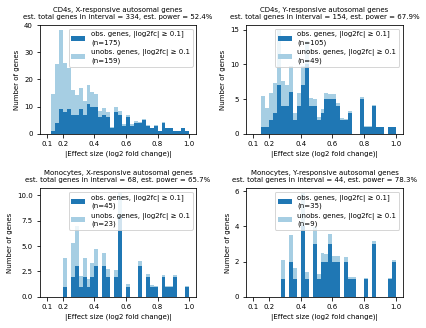

In [20]:
fig, axes = plt.subplots(2, 2, figsize=(6.5, 5))
fig.subplots_adjust(hspace=0.5, wspace=0.32)

v_list = ['x', 'y']
cell_list = ['CD4s', 'Monocytes']
pow_list = [pow_l, pow_f]
res_list = [[xres_l, yres_l], 
            [xres_f, yres_f]]
for i in (0, 1):      # cell type
    for j in (0, 1):  # x vs. y
        ax = axes[i, j]
        cell = cell_list[i]
        v = '{}_count'.format(v_list[j])
        
        ax, cts, cts_true_est = plot_hist_unobserved_effects(ax, f, pow_list[i], res_list[i][j], 
                                                             v, bin_width=0.025)
        title = '{0}, {1}-responsive autosomal genes'.format(cell, v_list[j].upper())
        n_tot_est = int(np.sum(cts_true_est))
        est_power = np.sum(cts) / np.sum(cts_true_est)
        title += '\nest. total genes in interval = {0}, est. power = {1:.1%}'.format(n_tot_est, est_power)
        ax.set_title(title, size=7)
        
        for lab in ax.get_xticklabels():
            lab.set_size(7)
        for lab in ax.get_yticklabels():
            lab.set_size(7)

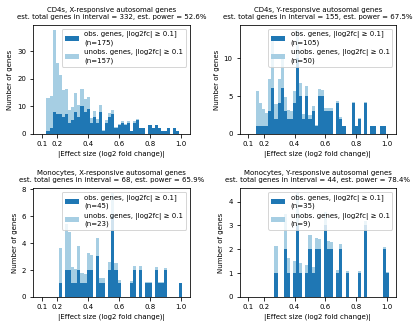

In [21]:
fig, axes = plt.subplots(2, 2, figsize=(6.5, 5))
fig.subplots_adjust(hspace=0.5, wspace=0.32)

v_list = ['x', 'y']
cell_list = ['CD4s', 'Monocytes']
pow_list = [pow_l, pow_f]
res_list = [[xres_l, yres_l], 
            [xres_f, yres_f]]
for i in (0, 1):      # cell type
    for j in (0, 1):  # x vs. y
        ax = axes[i, j]
        cell = cell_list[i]
        v = '{}_count'.format(v_list[j])
        
        ax, cts, cts_true_est = plot_hist_unobserved_effects(ax, f, pow_list[i], res_list[i][j], 
                                                             v, bin_width=0.02, b_range=[0.09, 1.01])
        title = '{0}, {1}-responsive autosomal genes'.format(cell, v_list[j].upper())
        n_tot_est = int(np.sum(cts_true_est))
        est_power = np.sum(cts) / np.sum(cts_true_est)
        title += '\nest. total genes in interval = {0}, est. power = {1:.1%}'.format(n_tot_est, est_power)
        ax.set_title(title, size=7)
        
        for lab in ax.get_xticklabels():
            lab.set_size(7)
        for lab in ax.get_yticklabels():
            lab.set_size(7)

In [ ]:
fig, ax = plt.subplots()

plot_hist_unobserved_effects(ax, f, pow_l, xres_l, 'x_count', bin_width=0.02)

In [ ]:
df = pow_l.loc[pow_l['variable']=='y_count']
eff_obs = sig_effects_y

eff_obs = np.abs(eff_obs)
eff_obs = eff_obs[eff_obs >= 0.1]

df = df.loc[df['beta'] > 0.05]
meds = df.groupby('beta').median()[['TPR']].reset_index()

def f(x, a, b):
    return 1-a*np.exp(-b*x)

popt, pcov = so.curve_fit(f, df['beta'], df['TPR'])

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

ax1.scatter(df['beta'], df['TPR'], alpha=0.25)
ax1.scatter(meds['beta'], meds['TPR'], marker='_', lw=2, zorder=3)

xs = np.linspace(0.1, 1, 40)
ys = np.array(list(map(lambda x: f(x, popt[0], popt[1]), xs)))
ax1.plot(xs, ys)

# estimate density for values of beta between 0.1 to 1.0 (exclusive) in bins of width 0.05
bwidth = 0.05
b0 = 0.1
b1 = 1.0
bins = int((b1 - b0) / bwidth)
cts, breaks, patches = ax2.hist(eff_obs, range=(b0, b1), bins=bins)
xs1 = np.arange(bins)*bwidth + b0+(0.5*bwidth)
est_power = np.array(list(map(lambda x: f(x, popt[0], popt[1]), xs1)))

cts_true_est = cts / est_power
ax2.bar(xs1, cts_true_est-cts, bwidth, bottom=cts, color='#a6cee3')

print("Observed genes with effects beta in ({0}, {1}), n={2}".format(b0, b1, np.sum(cts)))
print("Estimated number of genes in interval, n={0:.1f}".format(np.sum(cts_true_est)))
print("Estimated power = {:.1%}".format(np.sum(cts) / np.sum(cts_true_est)))

In [ ]:
df = pow_l.loc[pow_l['variable']=='y_count']
eff_obs = sig_effects_y

eff_obs = np.abs(eff_obs)
eff_obs = eff_obs[eff_obs >= 0.1]

df = df.loc[df['beta'] > 0.05]
meds = df.groupby('beta').median()[['TPR']].reset_index()

def f(x, a, b):
    return 1-a*np.exp(-b*x)

popt, pcov = so.curve_fit(f, df['beta'], df['TPR'])

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

ax1.scatter(df['beta'], df['TPR'], alpha=0.25)
ax1.scatter(meds['beta'], meds['TPR'], marker='_', lw=2, zorder=3)

xs = np.linspace(0.1, 1, 40)
ys = np.array(list(map(lambda x: f(x, popt[0], popt[1]), xs)))
ax1.plot(xs, ys)

# estimate density for values of beta between 0.1 to 1.0 (exclusive) in bins of width 0.05
bwidth = 0.05
b0 = 0.1
b1 = 1.0
bins = int((b1 - b0) / bwidth)
cts, breaks, patches = ax2.hist(eff_obs, range=(b0, b1), bins=bins)
xs1 = np.arange(bins)*bwidth + b0+(0.5*bwidth)
est_power = np.array(list(map(lambda x: f(x, popt[0], popt[1]), xs1)))

cts_true_est = cts / est_power
ax2.bar(xs1, cts_true_est-cts, bwidth, bottom=cts, color='#a6cee3')

print("Observed genes with effects beta in ({0}, {1}), n={2}".format(b0, b1, np.sum(cts)))
print("Estimated number of genes in interval, n={0:.1f}".format(np.sum(cts_true_est)))
print("Estimated power = {:.1%}".format(np.sum(cts) / np.sum(cts_true_est)))

In [ ]:
df = pow_l.loc[pow_l['variable']=='x_count']
eff_obs = sig_effects_x

eff_obs = np.abs(eff_obs)
eff_obs = eff_obs[eff_obs >= 0.1]

df = df.loc[df['beta'] > 0.05]
meds = df.groupby('beta').median()[['TPR']].reset_index()

def f(x, a, b):
    return 1-a*np.exp(-b*x)

popt, pcov = so.curve_fit(f, df['beta'], df['TPR'])

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

ax1.scatter(df['beta'], df['TPR'], alpha=0.25)
ax1.scatter(meds['beta'], meds['TPR'], marker='_', lw=2, zorder=3)

xs = np.linspace(0.1, 1, 40)
ys = np.array(list(map(lambda x: f(x, popt[0], popt[1]), xs)))
ax1.plot(xs, ys)

# estimate density for values of beta between 0.1 to 1.0 (exclusive) in bins of width 0.05
bwidth = 0.05
b0 = 0.1
b1 = 1.0
bins = int((b1 - b0) / bwidth)
cts, breaks, patches = ax2.hist(eff_obs, range=(b0, b1), bins=bins)
xs1 = np.arange(bins)*bwidth + b0+(0.5*bwidth)
est_power = np.array(list(map(lambda x: f(x, popt[0], popt[1]), xs1)))

cts_true_est = cts / est_power
ax2.bar(xs1, cts_true_est-cts, bwidth, bottom=cts, color='#a6cee3')

print("Observed genes with effects beta in ({0}, {1}), n={2}".format(b0, b1, np.sum(cts)))
print("Estimated number of genes in interval, n={0:.1f}".format(np.sum(cts_true_est)))
print("Estimated power = {:.1%}".format(np.sum(cts) / np.sum(cts_true_est)))

Monocytes

In [ ]:
df = pow_f.loc[pow_f['variable']=='y_count']
eff_obs = sig_effects_yf

eff_obs = np.abs(eff_obs)
eff_obs = eff_obs[eff_obs >= 0.1]

df = df.loc[df['beta'] > 0.05]
meds = df.groupby('beta').median()[['TPR']].reset_index()

def f(x, a, b):
    return 1-a*np.exp(-b*x)

popt, pcov = so.curve_fit(f, df['beta'], df['TPR'])

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

ax1.scatter(df['beta'], df['TPR'], alpha=0.25)
ax1.scatter(meds['beta'], meds['TPR'], marker='_', lw=2, zorder=3)

xs = np.linspace(0.1, 1, 40)
ys = np.array(list(map(lambda x: f(x, popt[0], popt[1]), xs)))
ax1.plot(xs, ys)

# estimate density for values of beta between 0.1 to 1.0 (exclusive) in bins of width 0.05
bwidth = 0.05
b0 = 0.1
b1 = 1.0
bins = int((b1 - b0) / bwidth)
cts, breaks, patches = ax2.hist(eff_obs, range=(b0, b1), bins=bins)
xs1 = np.arange(bins)*bwidth + b0+(0.5*bwidth)
est_power = np.array(list(map(lambda x: f(x, popt[0], popt[1]), xs1)))

cts_true_est = cts / est_power
ax2.bar(xs1, cts_true_est-cts, bwidth, bottom=cts, color='#a6cee3')

print("Observed genes with effects beta in ({0}, {1}), n={2}".format(b0, b1, np.sum(cts)))
print("Estimated number of genes in interval, n={0:.1f}".format(np.sum(cts_true_est)))
print("Estimated power = {:.1%}".format(np.sum(cts) / np.sum(cts_true_est)))

In [ ]:
df = pow_f.loc[pow_f['variable']=='y_count']
eff_obs = sig_effects_yf

eff_obs = np.abs(eff_obs)
eff_obs = eff_obs[eff_obs >= 0.1]

df = df.loc[df['beta'] > 0.05]
meds = df.groupby('beta').median()[['TPR']].reset_index()

def f(x, a, b):
    return 1-a*np.exp(-b*x)

popt, pcov = so.curve_fit(f, df['beta'], df['TPR'])

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

ax1.scatter(df['beta'], df['TPR'], alpha=0.25)
ax1.scatter(meds['beta'], meds['TPR'], marker='_', lw=2, zorder=3)

xs = np.linspace(0.1, 1, 40)
ys = np.array(list(map(lambda x: f(x, popt[0], popt[1]), xs)))
ax1.plot(xs, ys)

# estimate density for values of beta between 0.1 to 1.0 (exclusive) in bins of width 0.05
bwidth = 0.05
b0 = 0.1
b1 = 1.0
bins = int((b1 - b0) / bwidth)
cts, breaks, patches = ax2.hist(eff_obs, range=(b0, b1), bins=bins)
xs1 = np.arange(bins)*bwidth + b0+(0.5*bwidth)
est_power = np.array(list(map(lambda x: f(x, popt[0], popt[1]), xs1)))

cts_true_est = cts / est_power
ax2.bar(xs1, cts_true_est-cts, bwidth, bottom=cts, color='#a6cee3')

print("Observed genes with effects beta in ({0}, {1}), n={2}".format(b0, b1, np.sum(cts)))
print("Estimated number of genes in interval, n={0:.1f}".format(np.sum(cts_true_est)))
print("Estimated power = {:.1%}".format(np.sum(cts) / np.sum(cts_true_est)))

In [ ]:
df = pow_f.loc[pow_f['variable']=='x_count']
eff_obs = sig_effects_xf

eff_obs = np.abs(eff_obs)
eff_obs = eff_obs[eff_obs >= 0.1]

df = df.loc[df['beta'] > 0.05]
meds = df.groupby('beta').median()[['TPR']].reset_index()

def f(x, a, b):
    return 1-a*np.exp(-b*x)

popt, pcov = so.curve_fit(f, df['beta'], df['TPR'])

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

ax1.scatter(df['beta'], df['TPR'], alpha=0.25)
ax1.scatter(meds['beta'], meds['TPR'], marker='_', lw=2, zorder=3)

xs = np.linspace(0.1, 1, 40)
ys = np.array(list(map(lambda x: f(x, popt[0], popt[1]), xs)))
ax1.plot(xs, ys)

# estimate density for values of beta between 0.1 to 1.0 (exclusive) in bins of width 0.05
bwidth = 0.05
b0 = 0.1
b1 = 1.0
bins = int((b1 - b0) / bwidth)
cts, breaks, patches = ax2.hist(eff_obs, range=(b0, b1), bins=bins)
xs1 = np.arange(bins)*bwidth + b0+(0.5*bwidth)
est_power = np.array(list(map(lambda x: f(x, popt[0], popt[1]), xs1)))

cts_true_est = cts / est_power
ax2.bar(xs1, cts_true_est-cts, bwidth, bottom=cts, color='#a6cee3')

print("Observed genes with effects beta in ({0}, {1}), n={2}".format(b0, b1, np.sum(cts)))
print("Estimated number of genes in interval, n={0:.1f}".format(np.sum(cts_true_est)))
print("Estimated power = {:.1%}".format(np.sum(cts) / np.sum(cts_true_est)))